In [1]:
!pip install torchxrayvision

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from transformers import ViTForImageClassification, ViTConfig
import random
import wandb
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [3]:
wandb.init(project="ViT",
           entity="omarammar0"
           )

wandb: Currently logged in as: omarammar0. Use `wandb login --relogin` to force relogin


In [4]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [5]:
dataset_path = '/kaggle/input/knee-dataset2/Dataset knee'

class_labels = sorted(os.listdir(dataset_path))

images = []
labels = []

for label, class_label in enumerate(class_labels):
    class_path = os.path.join(dataset_path, class_label)

    for image_name in os.listdir(class_path):
        images.append(image_name)
        labels.append(label)

images = np.array(images)
labels = np.array(labels)

df = pd.DataFrame({'image_id': images, 'label': labels})

df = df.sample(frac=1).reset_index(drop=True)

train_val, test = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)
train, validation = train_test_split(train_val, test_size=0.1, stratify=train_val['label'], random_state=42)

train = train.reset_index(drop=True)
validation = validation.reset_index(drop=True)
test = test.reset_index(drop=True)
Cases = {i: class_labels[i] for i in range(len(class_labels))}

In [6]:
Cases = {}
for i in range(len(class_labels)):
    Cases[i] = class_labels[i]
print(Cases)

print('----------------------------------------------------')
print("Number of Images in training : " , len(train))
print("Number of Images in validation : " , len(validation))
print("Number of Images in testing : " , len(test))
print("Total Images : " , len(train)+len(validation)+len(test))
print('----------------------------------------------------')


x = ["Train", "Test", "Validation"]
data = [train , test , validation]
c = 0
for i in data:
    print("----- {} -----".format(x[c]))
    for j in Cases:
        print("{}: {}".format(Cases[j],len(i[i["label"] == j])))
    c += 1

{0: 'Normal', 1: 'Osteopenia', 2: 'Osteoporosis'}
----------------------------------------------------
Number of Images in training :  481
Number of Images in validation :  54
Number of Images in testing :  60
Total Images :  595
----------------------------------------------------
----- Train -----
Normal: 150
Osteopenia: 169
Osteoporosis: 162
----- Test -----
Normal: 19
Osteopenia: 21
Osteoporosis: 20
----- Validation -----
Normal: 17
Osteopenia: 19
Osteoporosis: 18


In [7]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(dataset_path, Cases[self.df.iloc[idx, 1]], self.df.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.df.iloc[idx, 1]
        return image, label

In [8]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(15),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = CustomDataset(train, transform=train_transform)
validation_dataset = CustomDataset(validation, transform=test_transform)
test_dataset = CustomDataset(test, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

In [9]:
config = ViTConfig.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', config=config)

for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Linear(model.config.hidden_size, len(class_labels))  # Update number of classes

for param in model.classifier.parameters():
    param.requires_grad = True
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=7)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
EPOCHS = 100
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    running_loss /= len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(validation_loader.dataset)
    val_accuracy = 100 * correct_val / total_val
    scheduler.step(val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{EPOCHS}, Training Loss: {running_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%, Learning Rate: {current_lr}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_vit.pth')
        wandb.save('best_model_vit.pth')

    # Log metrics to wandb
    wandb.log({
        "epoch": epoch + 1,
        "training_loss": running_loss,
        "training_accuracy": train_accuracy,
        "validation_loss": val_loss,
        "validation_accuracy": val_accuracy,
        "learning_rate": current_lr
    })

Epoch 1/100, Training Loss: 4.9431, Validation Loss: 1.5608, Training Accuracy: 34.72%, Validation Accuracy: 51.85%, Learning Rate: 0.1
Epoch 2/100, Training Loss: 1.2858, Validation Loss: 1.0600, Training Accuracy: 49.90%, Validation Accuracy: 57.41%, Learning Rate: 0.1
Epoch 3/100, Training Loss: 0.9100, Validation Loss: 0.8086, Training Accuracy: 62.79%, Validation Accuracy: 59.26%, Learning Rate: 0.1
Epoch 4/100, Training Loss: 1.0928, Validation Loss: 1.2408, Training Accuracy: 56.96%, Validation Accuracy: 50.00%, Learning Rate: 0.1
Epoch 5/100, Training Loss: 1.1686, Validation Loss: 0.8288, Training Accuracy: 54.89%, Validation Accuracy: 61.11%, Learning Rate: 0.1
Epoch 6/100, Training Loss: 1.1520, Validation Loss: 0.8865, Training Accuracy: 56.34%, Validation Accuracy: 61.11%, Learning Rate: 0.1
Epoch 7/100, Training Loss: 0.8505, Validation Loss: 0.7774, Training Accuracy: 61.54%, Validation Accuracy: 64.81%, Learning Rate: 0.1
Epoch 8/100, Training Loss: 0.7671, Validation L

In [11]:
model.load_state_dict(torch.load('best_model_vit.pth'))
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Test Accuracy: ', 100 * correct / total, '%')


Test Accuracy:  71.66666666666667 %


In [12]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [13]:
def plot_images(images, labels, classes, normalize=False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min=image_min, max=image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

In [14]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x).logits  # Ensure to get the logits for ViT model

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs


In [15]:
def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm_display.plot(values_format='d', cmap='Blues', ax=ax)
    ax.set_title("Best Model ViT")
    plt.xticks(rotation=20)

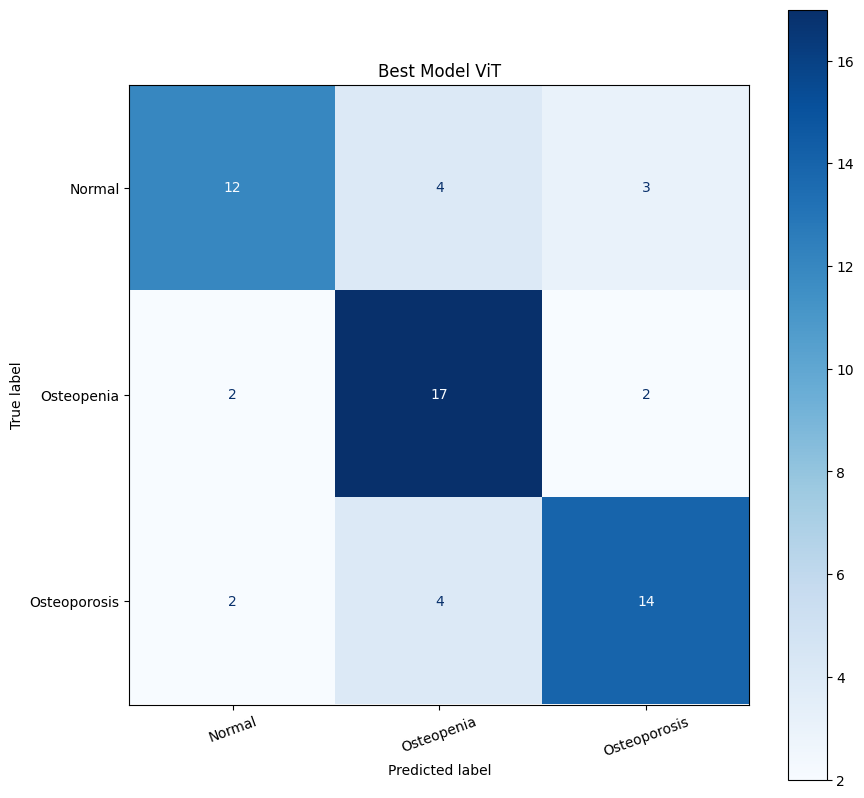

In [16]:
images, labels, probs = get_predictions(model, test_loader, device)
pred_labels = torch.argmax(probs, 1)

# Plot confusion matrix
plot_confusion_matrix(labels, pred_labels, class_labels)
corrects = torch.eq(labels, pred_labels)